In [1]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
print('The data directory is homedir: %s' %homedir)

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis
The data directory is homedir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655


In [360]:
#Import modules #Run this once

import numpy as np
import pandas as pd
import os.path
from pylab import *
import glob
import os
import re
from xlwt import Workbook
from scipy.optimize import curve_fit
global pointnumber
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model, Parameter, Parameters
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Simulation

## rand_on_off_time

In [2]:
def rand_on_off_times(ton=1, toff1=1, toff2=10, multiplier=100, numpoints=1000):
    '''ton, toff1, toff2 are in millisecond
    multiplier: time resolution
    '''
    #on times
    on_rand_exp = np.random.exponential(ton*multiplier,numpoints);
    on_rand_exp = np.round(on_rand_exp);
    #off times
    off_exp1 = np.random.exponential(toff1*multiplier,numpoints);
    off_exp1 = np.round(off_exp1)
    off_exp2 = np.random.exponential(toff2*multiplier,numpoints);
    off_exp2 = np.round(off_exp2);
    off_rand_exp = off_exp2;
    off_rand_biexp = off_exp2 - off_exp1;
    return on_rand_exp, off_rand_exp,off_rand_biexp

In [205]:
on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=1, toff1=1, toff2=10,
                                                             multiplier=100, numpoints=10000)
# figure(figsize=(10, 8))
# hist(off_rand_biexp - min(off_rand_biexp), bins=100);

## trace_on_off

In [3]:
def trace_on_off(ton=10, toff1=1, toff2=100, multiplier=1000, numpoints=100,
                oncounts=2500, offcounts=200):
    ''''''
    on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=ton, toff1=toff1, toff2=toff2,
                                                             multiplier=multiplier, numpoints=numpoints)
    intensity = []
    for i in range(len(off_rand_exp)):
        #on-times
        ran_on = randn(on_rand_exp[i])
        intensity_on = oncounts * np.ones(on_rand_exp[i])
        intensity_on = intensity_on + intensity_on *0.025*ran_on
        intensity = np.concatenate((intensity, intensity_on), axis=0)
        #off time
        ran_off = 3 + randn(off_rand_exp[i])
        intensity_off = offcounts * np.ones(off_rand_exp[i])
        intensity_off = intensity_off + intensity_off*0.25*ran_off
        intensity = np.concatenate((intensity, intensity_off), axis=0)
    time = linspace(1, len(intensity), len(intensity))
    return time, intensity

### time trace plot

(0, 2894.6800280557463)

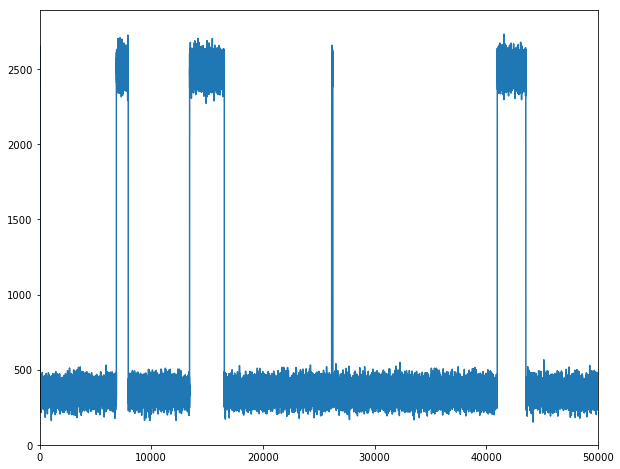

In [6]:
time, intensity = trace_on_off(ton=1, toff1=1, toff2=10, multiplier=1000, numpoints=100)
figure(figsize=(10, 8))
plot(time, intensity)
xlim(0, 50000)
ylim(0, None)

## trace_on_off_blink

In [83]:
def trace_on_off_blink(ton=10, toff1=1, toff2=100, ton_blink=1, toff_blink=0.1, toff_blink2=10,
                       multiplier=1000, numpoints=100,oncounts=2500, offcounts=200):
    ''''''
    on_rand_exp, off_rand_exp,off_rand_biexp = rand_on_off_times(ton=ton, toff1=toff1, toff2=toff2,
                                                             multiplier=multiplier, numpoints=numpoints)
    intensity = []
    for i in range(len(off_rand_exp)):
        #on-times
        ran_on = randn(on_rand_exp[i])
        intensity_on = oncounts * np.ones(on_rand_exp[i])
        
        numofpoints= 10 #len(intensity_on)/()
        on_rand_blink, off_rand_blink, off_rand_blinkbiexp = rand_on_off_times(ton=ton_blink, toff1=toff_blink, toff2=toff_blink2,
                                                                     multiplier=multiplier, numpoints=numofpoints)
        int_blink = []
        for j in range(len(on_rand_blink)):
            int_blink_on = oncounts * np.ones(on_rand_blink[j])#on times
            ran_on_blink = randn(len(int_blink_on))
            int_blink_on = int_blink_on + int_blink_on * ran_on_blink *0.025 #add noise
            int_blink = np.concatenate((int_blink, int_blink_on), axis=0)
            int_blink_off = offcounts * np.ones(off_rand_blink[j]) #off:devide my oncounts to make it 1
            ran_off_blink = 3 + randn(len(int_blink_off))
            int_blink_off = int_blink_off + int_blink_off*ran_off_blink*0.2 # 0.25 is 10 times 0.025
            int_blink = np.concatenate((int_blink, int_blink_off), axis=0)
        if len(intensity_on) < len(int_blink):
            intensity_on[:] = int_blink[:len(intensity_on)]
        else:
            intensity_on[:len(int_blink)] = int_blink[:]
            intensity_on = intensity[:len(int_blink)]
        intensity_on = intensity_on #+ intensity_on *0.025*ran_on
        intensity = np.concatenate((intensity, intensity_on), axis=0)
        #off time
        ran_off = 3 + randn(off_rand_exp[i])
        intensity_off = offcounts * np.ones(off_rand_exp[i])
        intensity_off = intensity_off + intensity_off*0.2*ran_off
        intensity = np.concatenate((intensity, intensity_off), axis=0)
    time = linspace(1, len(intensity), len(intensity))
    return time, intensity

### time trace plot

(0, 2891.5726398628144)

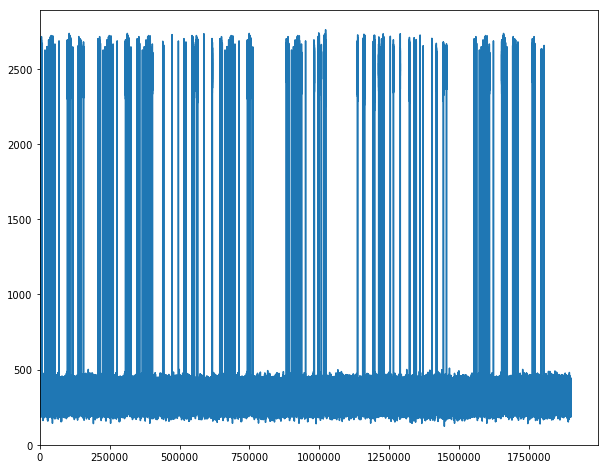

In [92]:
time, intensity = trace_on_off_blink(ton=100, toff1=1, toff2=50, ton_blink=1, toff_blink=0.1, toff_blink2=10,
                       multiplier=1000, numpoints=20,oncounts=2500, offcounts=200)
figure(figsize=(10, 8))
plot(time, intensity)
xlim(0, None)
ylim(0, None)

# Simulated from Experimental data

In [3]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
print('The data directory is homedir: %s' %homedir)

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis
The data directory is homedir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655


In [371]:
#Run this once to run the .py file.
os.chdir(parentdir)
!python Analysis_bis.py
%run Analysis_bis.py

In [3]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime'
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655, S105d15May17_60o5_635_A1_CuAzu655_longtime]
fold_201609 = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON, S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]
fold_201702 = [S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655];
fold_201705 = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

In [4]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False):
    t_ons = []; t_offs = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_datn_path, f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(20,8))
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on)
        axes[0].set_xlabel(r'$\tau_{on}$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off)
        axes[1].set_xlabel(r'$\tau_{off}$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)

In [5]:
def hist_2d_from_t_values(t_ons, t_offs,input_potential=100, x_shift=10, bins_on=40, range_on=[0, 0.01], bins_off=50, range_off=[0, 1], plots = True):
    t_ons=pd.Series(t_ons);t_offs=pd.Series(t_offs)
    t_on_shifted_1 = t_ons.shift(+1) ## shift up
    t_on_delay_1 = pd.DataFrame([t_on_shifted_1, t_ons]); t_on_delay_1=t_on_delay_1.T
    t_on_delay_1 = t_on_delay_1.dropna();
    t_off_shifted_1 = t_offs.shift(+1) ## shift up

    t_on_shifted_x = t_ons.shift(+x_shift) ## shift up
    t_off_shifted_x = t_offs.shift(+x_shift) ## shift up
    print('Number of on events: %d' %len(t_ons))
    print('Number of off events: %d' %len(t_offs))
    if plots==True:
        import matplotlib as mpl
        colormap=mpl.cm.RdBu_r
        fig = plt.figure(figsize=(16,8))

        ax1 = fig.add_subplot(2,3,1)#2,2,1
        C_on_1,Ex_on_1,Ey_on_1, figu = hist2d(t_on_shifted_1[1:], t_ons[1:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_1,Ey_on_1 = meshgrid(Ex_on_1,Ey_on_1)
        #ax1.pcolormesh(Ex_on_1, Ey_on_1, C_on_1, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax1.set_title('ON time Cu-Azu %smV' %input_potential)
        ax1.set_xlabel(r'$\tau_{on}/s$')
        ax1.set_ylabel(r'$\tau_{on}+1/s$')

        ax2 = fig.add_subplot(2,3,2)#2,2,1
        C_on_x,Ex_on_x,Ey_on_x, figu = hist2d(t_on_shifted_x[x_shift:], t_ons[x_shift:], range=[range_on, range_on], bins=bins_on, norm=mpl.colors.LogNorm(), cmap=colormap)
        Ex_on_x,Ey_on_x = meshgrid(Ex_on_x,Ey_on_x)
        #ax2.pcolormesh(Ex_on_x, Ey_on_x, C_on_x, cmap=colormap)#,norm=mpl.colors.LogNorm()
        colorbar()
        ax2.set_title('ON time Cu-Azu %smV' %input_potential)
        ax2.set_xlabel(r'$\tau_{on}/s$')
        ax2.set_ylabel(r'$\tau_{on}+%s/s$'%x_shift)

        ax3 = fig.add_subplot(2,3,3)
        C_on_diff = C_on_1-C_on_x;
        pcm=ax3.pcolormesh(Ex_on_x, Ey_on_x, C_on_diff,
                       norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_on_diff.min(), vmax=C_on_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax3, extend='max')

        ax4 = fig.add_subplot(2,3,4)
        C_off_1, Ex_off_1, Ey_off_1, figu= hist2d(t_off_shifted_1[1:], t_offs[1:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_1, Ey_off_1 = meshgrid(Ex_off_1, Ey_off_1)
        colorbar()
        ax4.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax4.set_xlabel(r'$\tau_{off}/s$')
        ax4.set_ylabel(r'$\tau_{off}+1/s$')

        ax5 = fig.add_subplot(2,3,5)
        C_off_x,Ex_off_x,Ey_off_x, figu = hist2d(t_off_shifted_x[x_shift:], t_offs[x_shift:], range=[range_off, range_off],bins=bins_off, norm=mpl.colors.LogNorm(), cmap=colormap);#, norm=mpl.colors.LogNorm()
        Ex_off_x,Ey_off_x = meshgrid(Ex_off_x,Ey_off_x)
        colorbar()
        ax5.set_title('OFF time Cu-Azu %smV' %input_potential)
        ax5.set_xlabel(r'$\tau_{off}/s$')
        ax5.set_ylabel(r'$\tau_{off}+%s/s$'%x_shift)

        ax6 = fig.add_subplot(2,3,6)
        C_off_diff=C_off_1-C_off_x
        pcm=ax6.pcolormesh(Ex_off_x, Ey_off_x, C_off_diff, norm=mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=C_off_diff.min(), vmax=C_off_diff.max()), cmap=colormap)
        fig.colorbar(pcm, ax=ax6, extend='max')
        plt.tight_layout()
        return()

Generating on off times from the distribution (probability distribution function) obtained in the experiment.
Resonable paramters:
100 mV: bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1]


em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


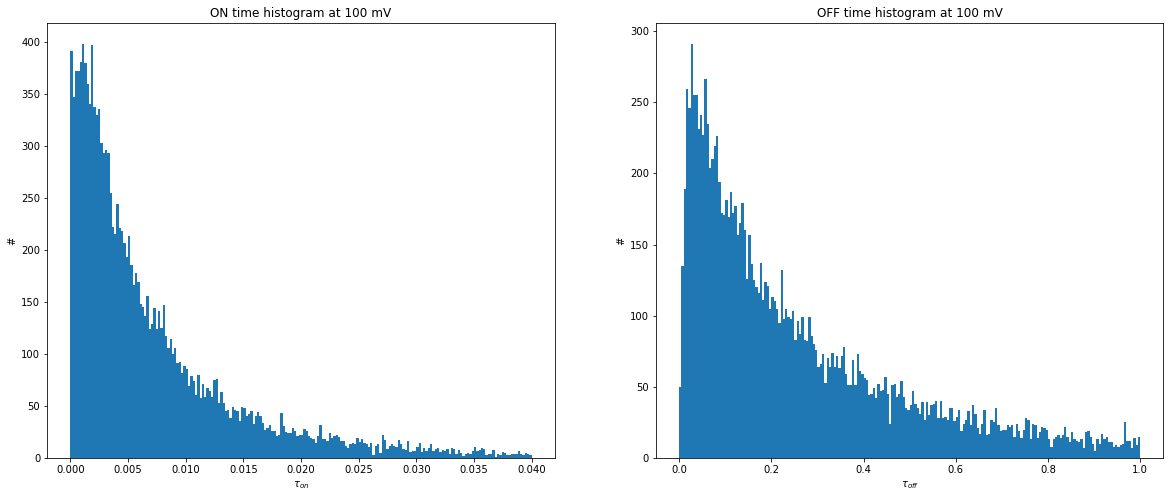

In [30]:
#
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100), 
                                        bins_on=200, range_on=[0, 0.04], bins_off=200, range_off=[0, 1], plotting=True)

prob_on = n_on/max(n_on); prob_on = prob_on/sum(prob_on);
prob_off = n_off/max(n_off); prob_off = prob_off/sum(prob_off);
data_points = 1e6
t_ons_generated = np.random.choice(bins_on[:-1], data_points, p=prob_on)
t_off_generated = np.random.choice(bins_off[:-1], data_points, p=prob_off)

Number of on events: 1000000
Number of off events: 1000000


()

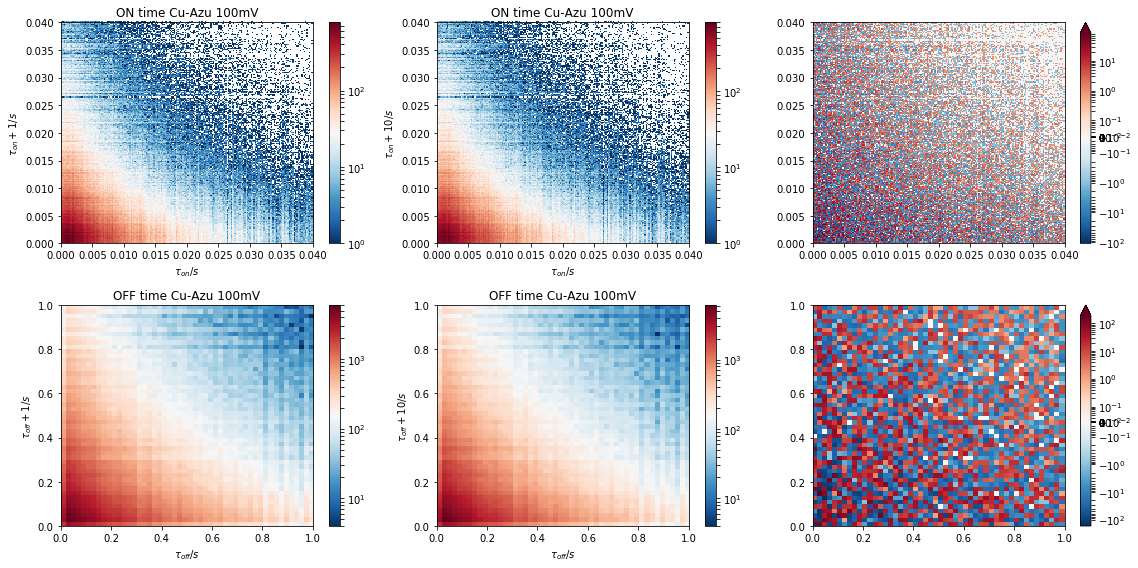

In [32]:
hist_2d_from_t_values(t_ons_generated, t_off_generated, x_shift=10, bins_on=200, range_on=[0, 0.04], bins_off=50, range_off=[0, 1], plots = True)

## Dynamic correlation

In [324]:
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
long_trace_files = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

In [ ]:
def histogram_on_off_1mol(foldername= foldername, input_potential=[100], pointnumbers=[1],
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False):
    df_datn_emplot, df_FCS, folder = dir_mV_molNo(foldername)
    df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
    df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
    f_emplot_path = 'x'; f_datn_path='x'; t_ons=[];t_offs=[];n_on = []; n_off = []
    if not df_specific.empty:
        f_datn_path = df_specific['filepath[.datn]'].values[0]
        f_emplot_path = df_specific['filepath[.em.plot]'].values[0]
        if os.path.isfile(f_emplot_path):
            try:
                df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_datn_path, f_emplot_path)
                t_ons = np.array(df_ton);
                t_offs = np.array(df_toff)
                n_on = []; n_off = []
                if plotting == True:
                    fig, axes = plt.subplots(1, 2, figsize=(10,4))
                    n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on, bins=bins_on, color='k', alpha=0.5)
                    n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on, bins=bins_on, color='k', histtype='step')
                    axes[0].set_xlabel(r'$\tau_{on}/s$')
                    axes[0].set_ylabel('PDF')
                    axes[0].set_xlim(0, None)
                    #axes[0].set_yscale('log')
                    axes[0].set_title("ON time histogram at %s mV of Point_%s" %(input_potential[0],pointnumbers))
                    n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off, color='k', alpha=0.5)
                    n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off, color='k', histtype='step')
                    axes[1].set_xlabel(r'$\tau_{off}/s$')
                    axes[1].set_ylabel('PDF')
                    axes[1].set_xlim(0, None)
                    #axes[1].set_yscale('log')
                    axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
            except:
                #print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                #potential=np.nan # This row will be removed in later processing
                pass
        return(fig, t_ons, t_offs, n_on, bins_on, n_off, bins_off)
    else:
        return None

# homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime'
# fig, t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=[50], pointnumbers=[23],
#                           bins_on=100, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], plotting=True)

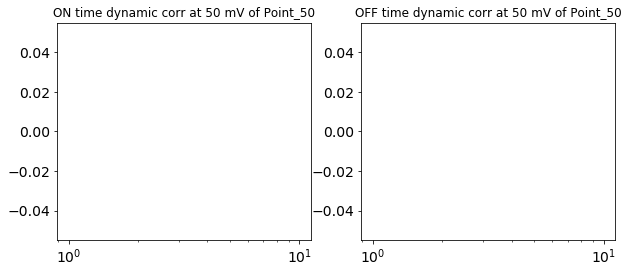

In [441]:
def dynamic_corr(t_ons=t_ons, t_offs=t_offs, potential=50, pointnumbers=50):
    temp = t_ons;#[t_ons>1e-3]
    tau = temp[:-1];#[len(temp)/2:-500]
    t_ij = [];
    for i in range(len(tau)-1):#range(len(tau_on_i)-1)
        D_t = tau[:(-1-i)]-average(tau);
        D_t_T = tau[i:-1]-average(tau);
        t_ij_temp = average(D_t * D_t_T)/(average(tau)**2)
        t_ij = np.append(t_ij,t_ij_temp)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(t_ij[:-100])
    axes[0].set_xscale('log')
    axes[0].set_title("ON time dynamic corr at %s mV of Point_%s" %(potential, pointnumbers), fontsize=12)
    temp = t_offs;#[t_ons>1e-3]
    tau = temp[:-1];#[len(temp)/2:-500]
    t_ij = [];
    for i in range(len(tau)-1):#range(len(tau_on_i)-1)
        D_t = tau[:(-1-i)]-average(tau);
        D_t_T = tau[i:-1]-average(tau);
        t_ij_temp = average(D_t * D_t_T)/(average(tau)**2)
        t_ij = np.append(t_ij,t_ij_temp)
    axes[1].plot(t_ij[:-100])
    axes[1].set_xscale('log')
    axes[0].set_title("ON time dynamic corr at %s mV of Point_%s" %(potential, pointnumbers), fontsize=12)
    axes[1].set_title("OFF time dynamic corr at %s mV of Point_%s" %(potential, pointnumbers), fontsize=12)
    return(fig)
fig = dynamic_corr()

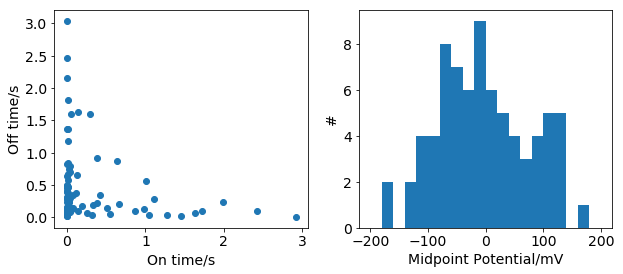

In [427]:
def scatter_pot(t_ons=t_ons, t_offs=t_offs, potential=potential):
    if len(t_ons)> len(t_offs):
        t_ons = t_ons[:len(t_offs)]
    else:
        t_offs = t_offs[:len(t_ons)]
    fig_scater, axes = plt.subplots(1,2, figsize=(10, 4))
    axes[0].scatter(t_ons, t_offs)
    axes[0].set_xlabel('On time/s')
    axes[0].set_ylabel('Off time/s')
    t_on_ratio = t_offs/t_ons
    E_0 = potential-59 * log10(t_on_ratio)
    axes[1].hist(E_0, bins=20, range=(-200, 200))
    axes[1].set_xlabel('Midpoint Potential/mV')
    axes[1].set_ylabel('#')
    return(fig_scater)
fig_scater = scatter_pot(t_ons=t_ons, t_offs=t_offs, potential=50)

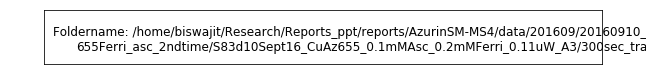

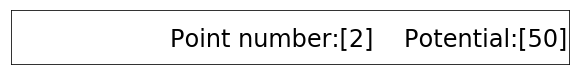

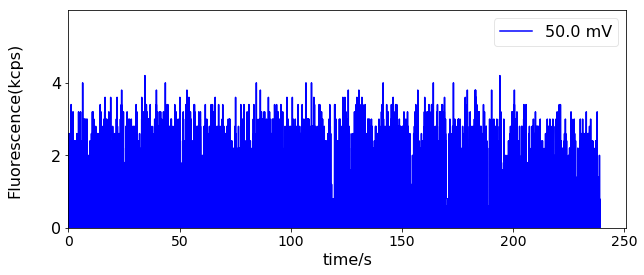

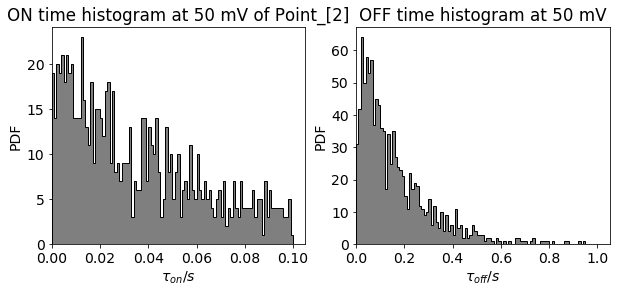

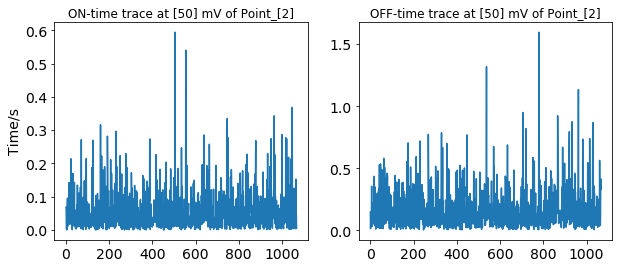

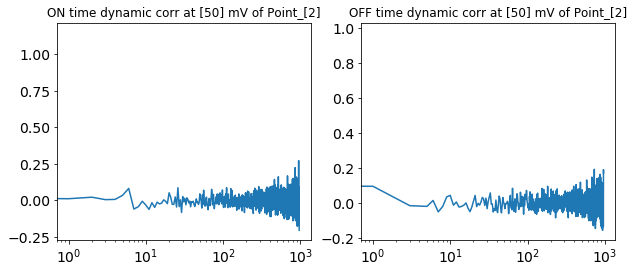

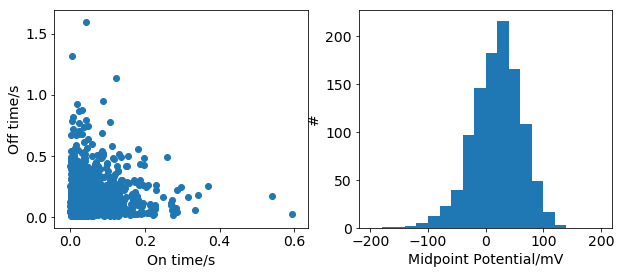

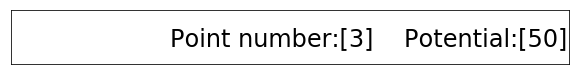

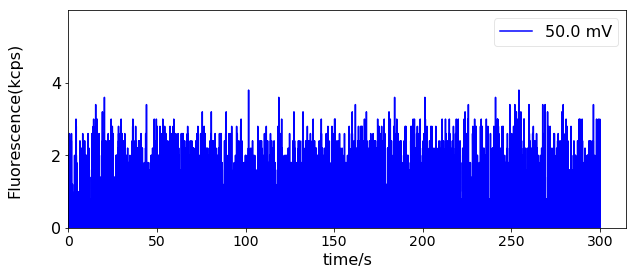

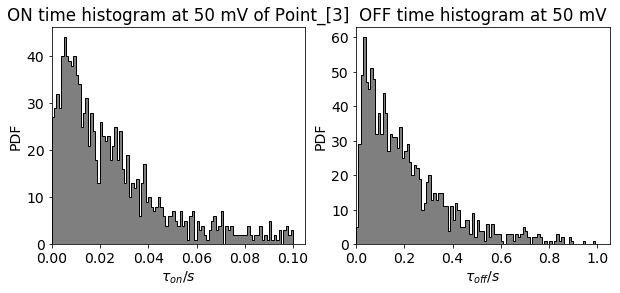

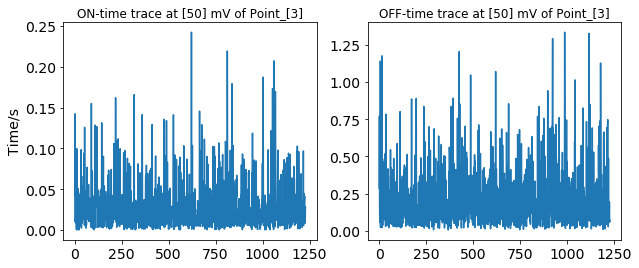

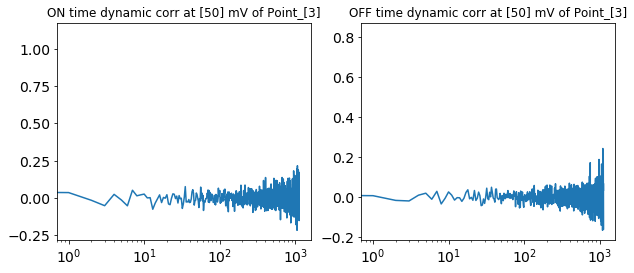

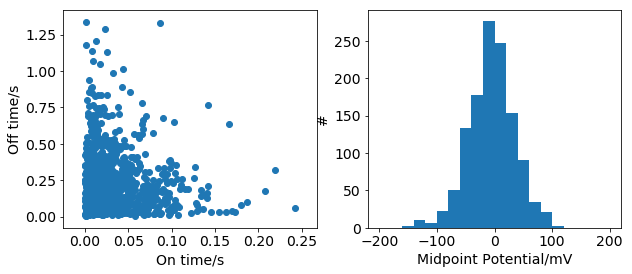

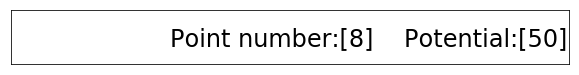

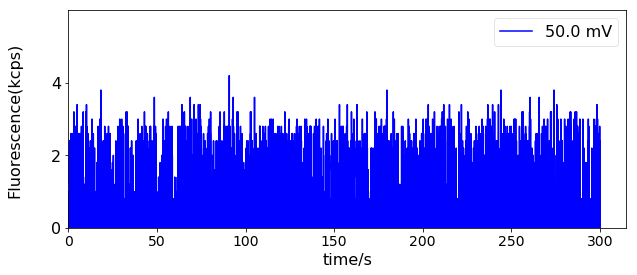

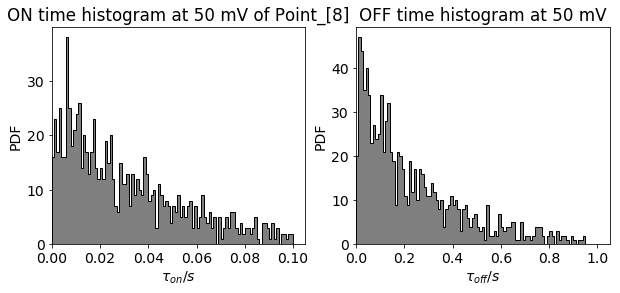

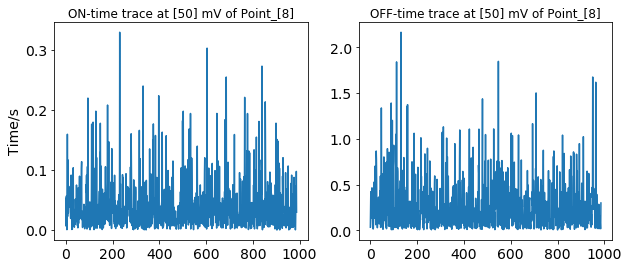

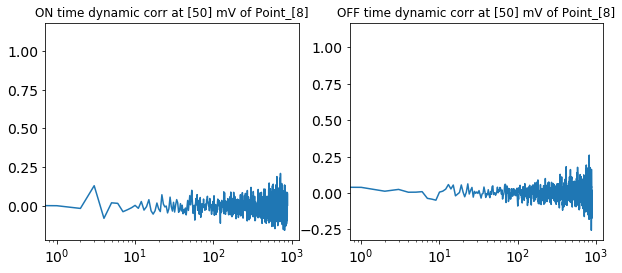

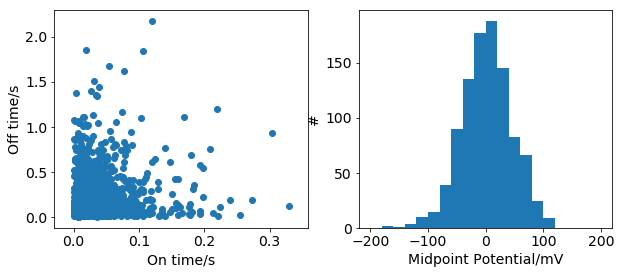

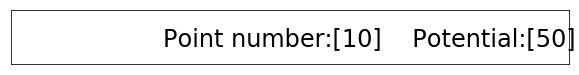

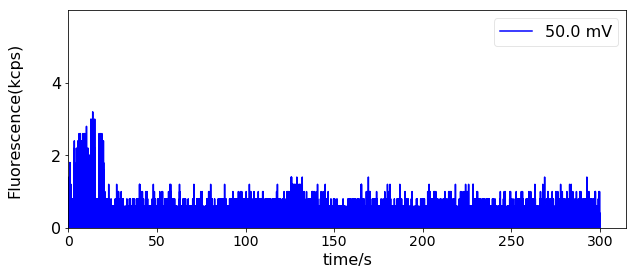

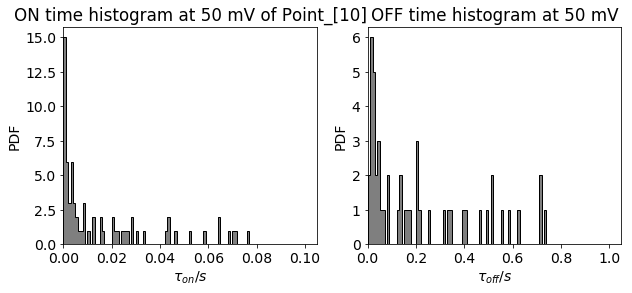

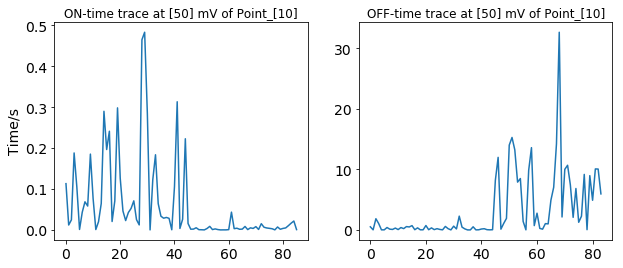

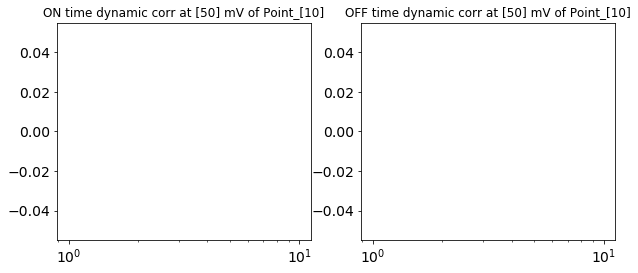

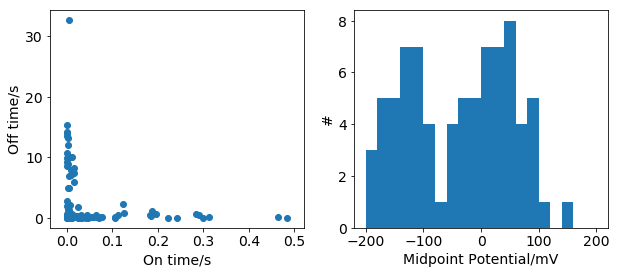

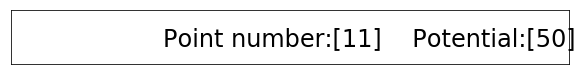

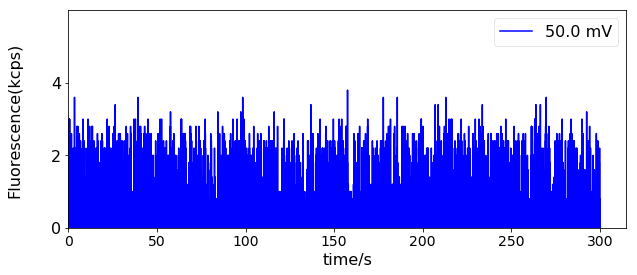

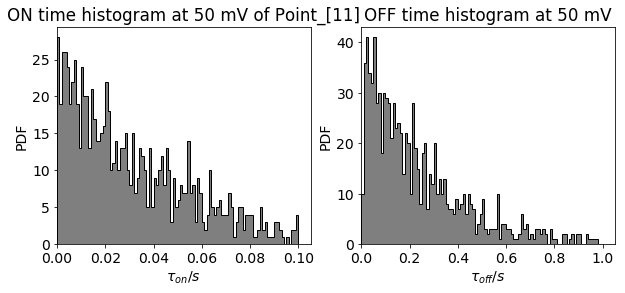

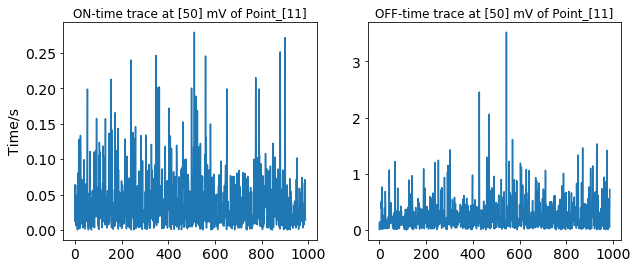

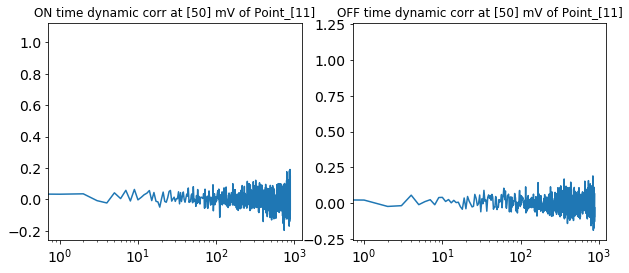

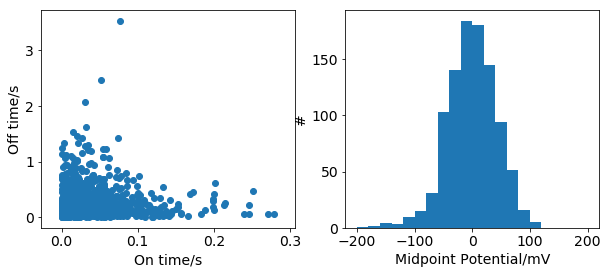

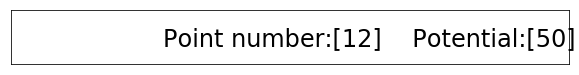

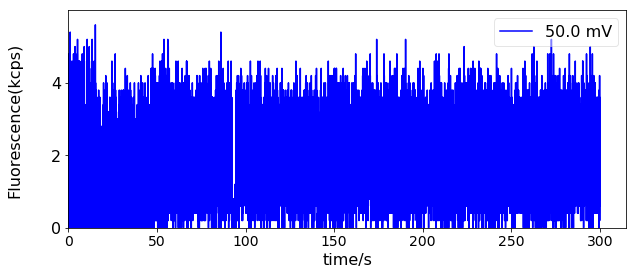

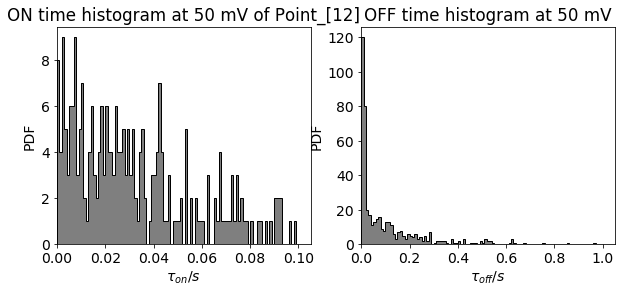

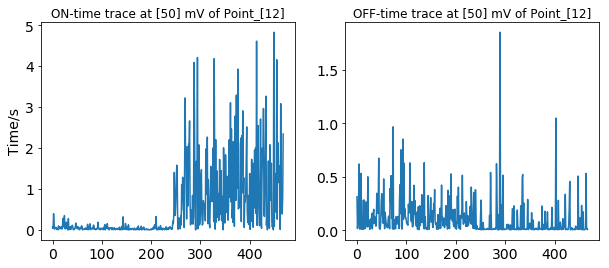

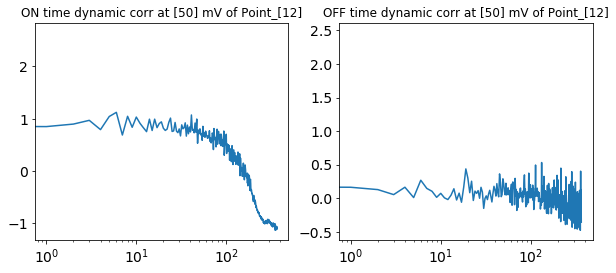

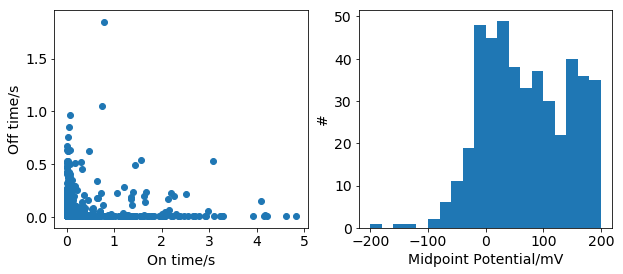

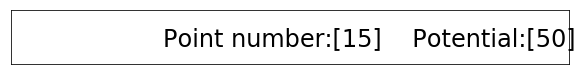

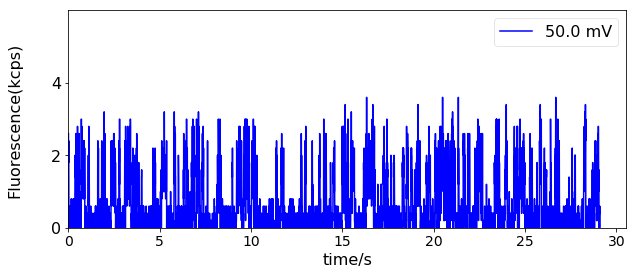

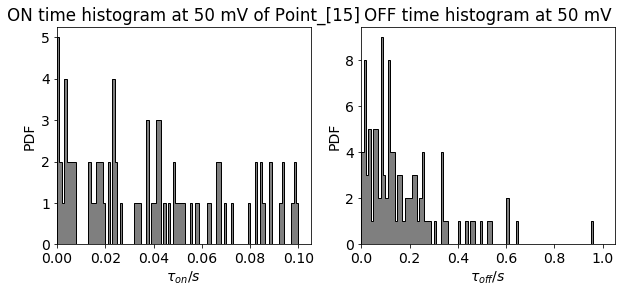

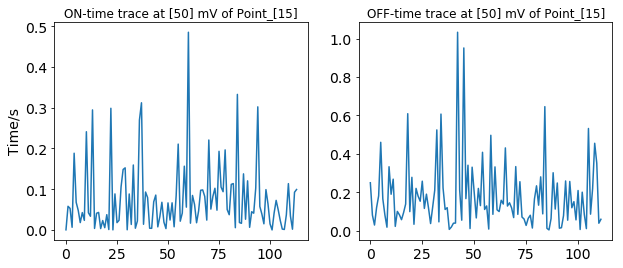

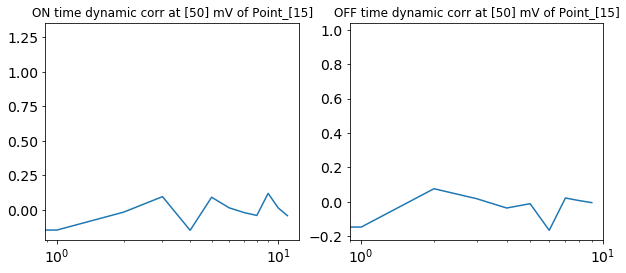

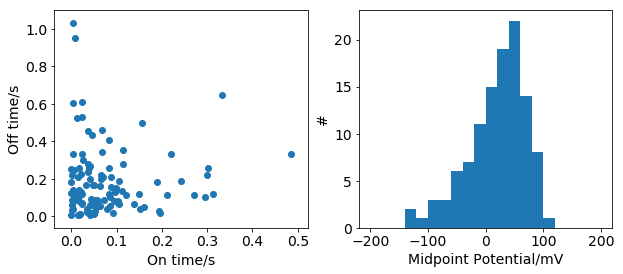

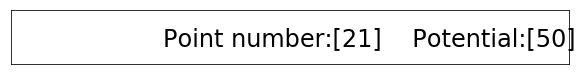

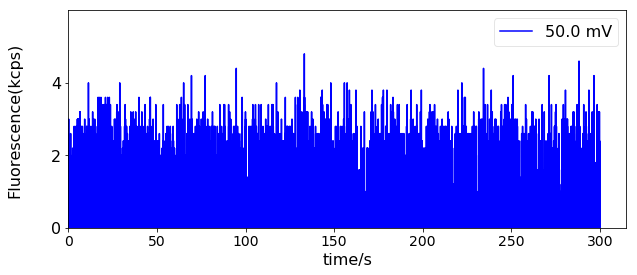

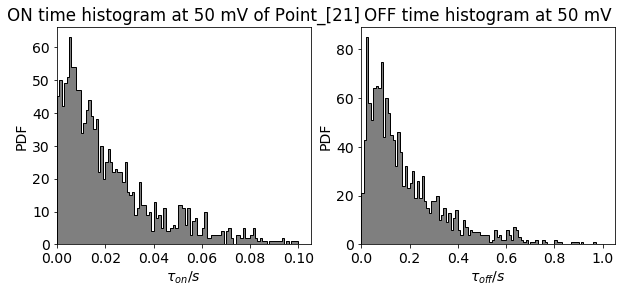

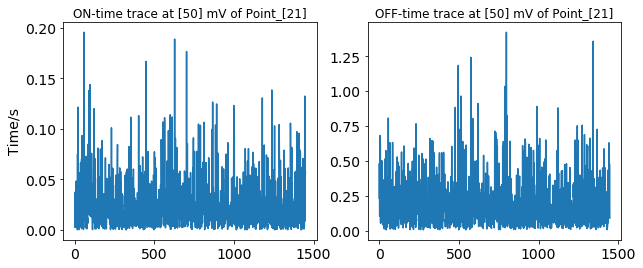

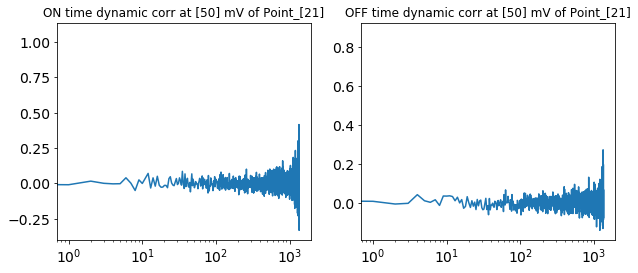

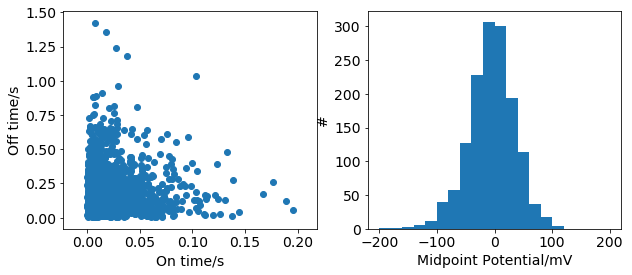

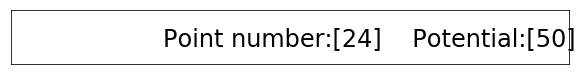

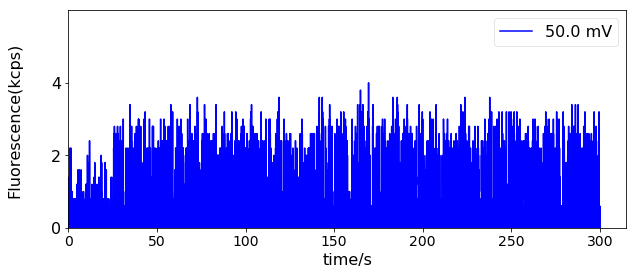

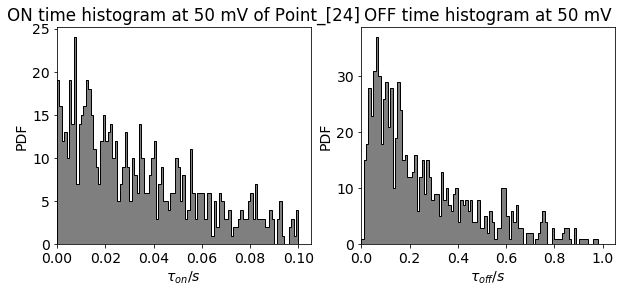

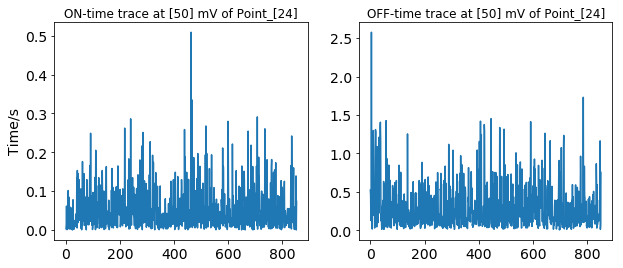

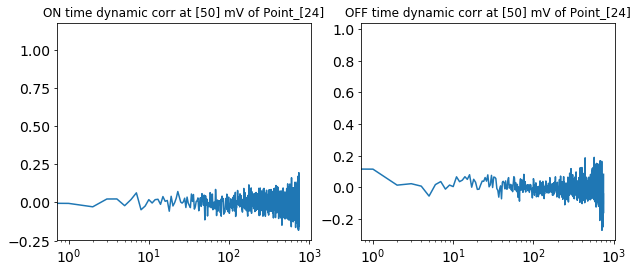

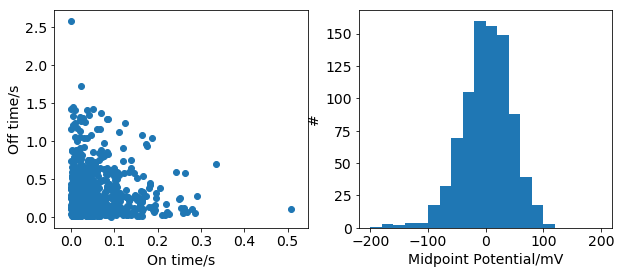

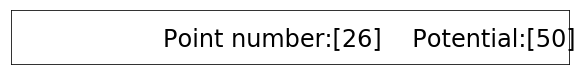

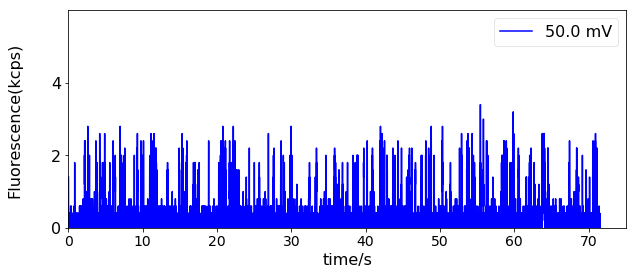

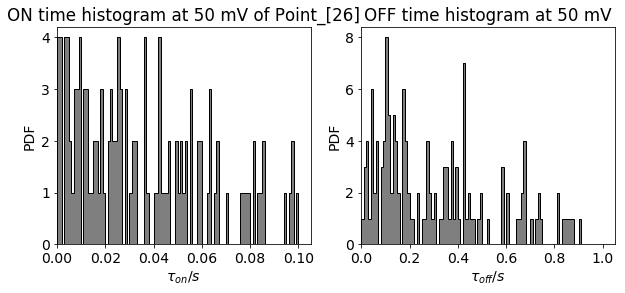

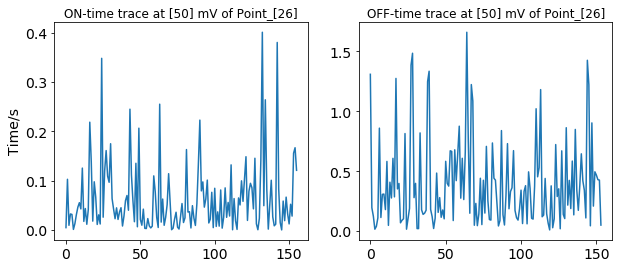

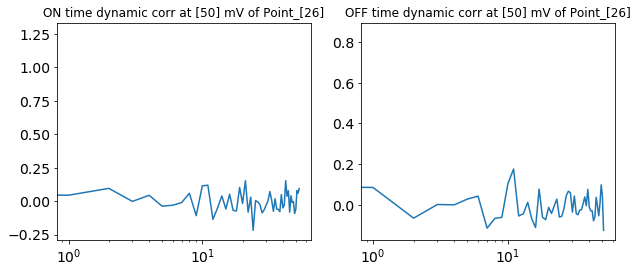

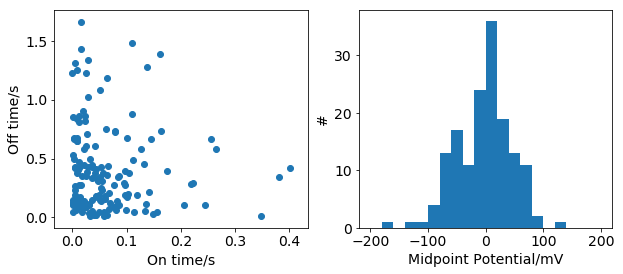

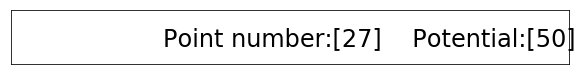

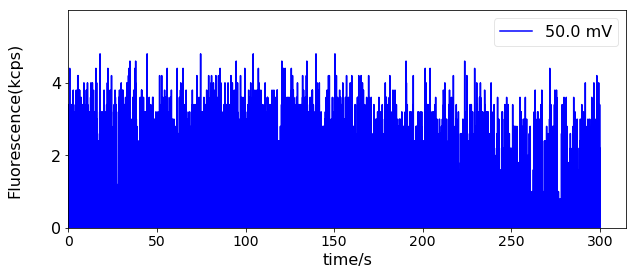

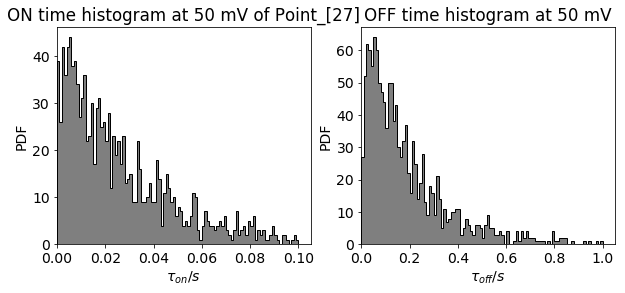

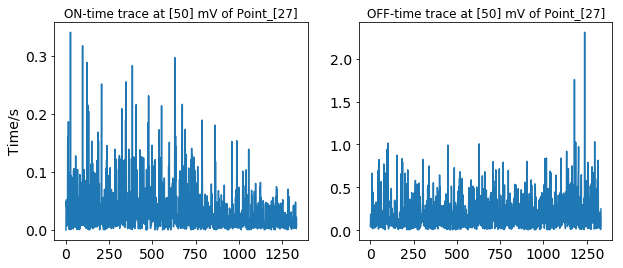

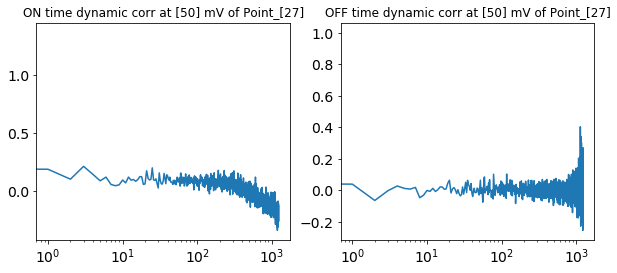

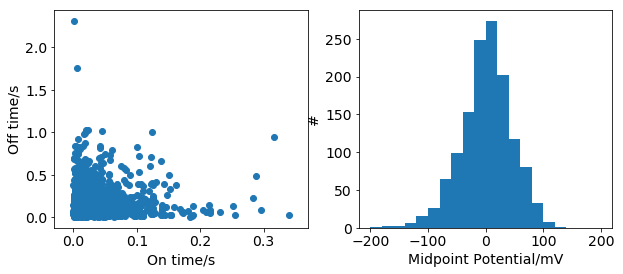

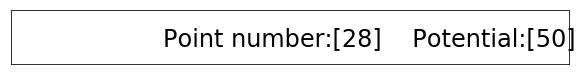

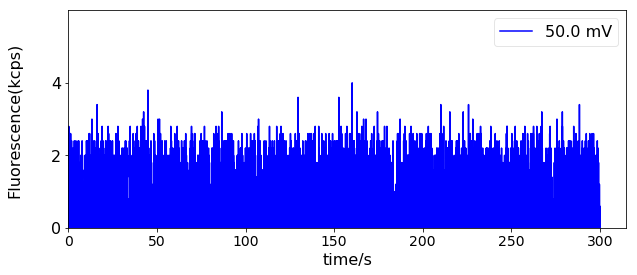

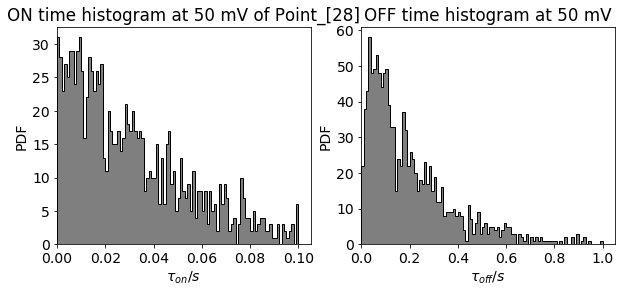

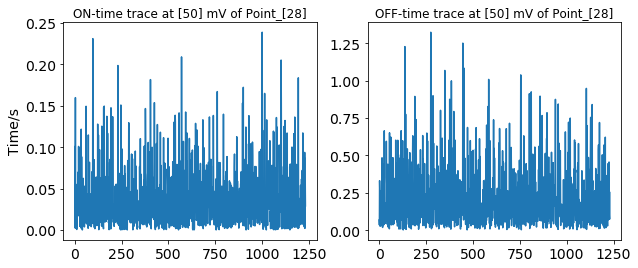

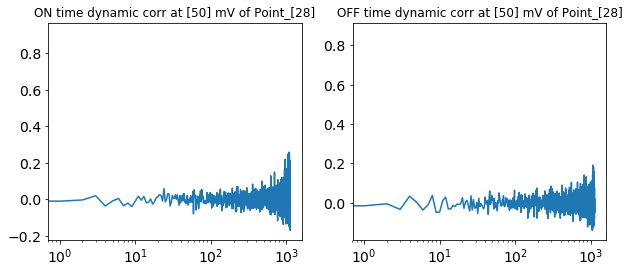

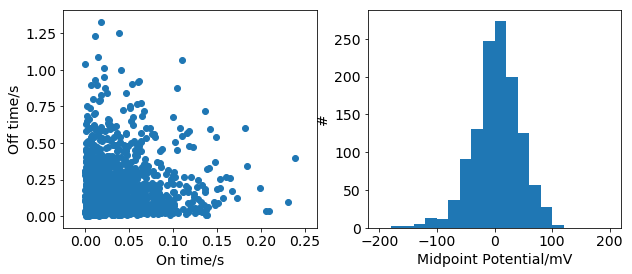

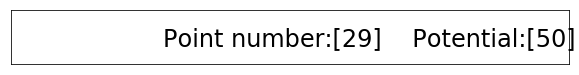

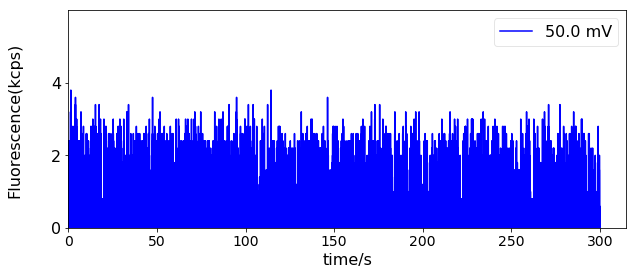

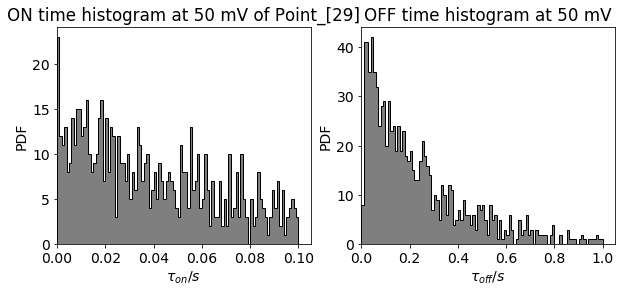

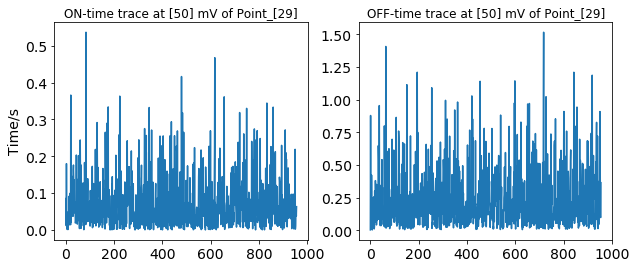

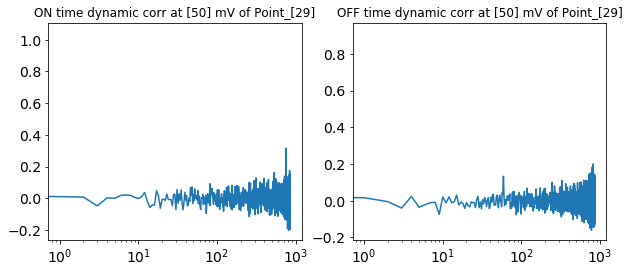

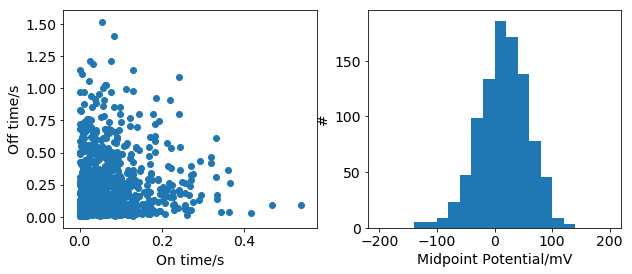

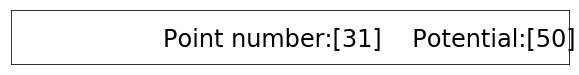

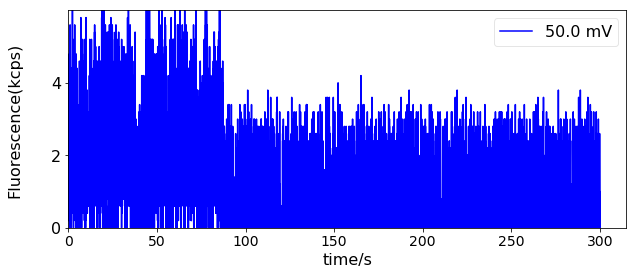

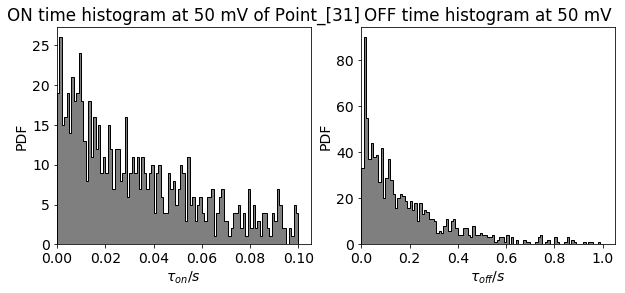

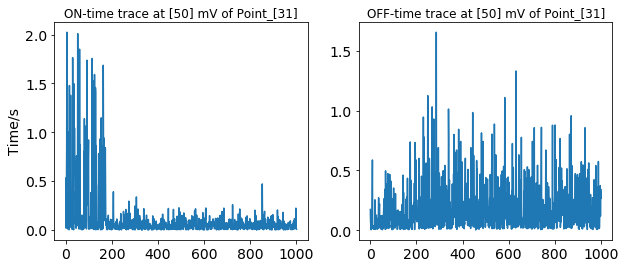

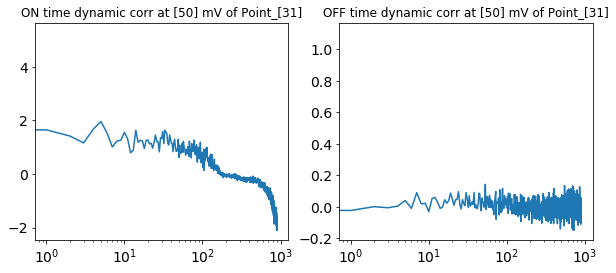

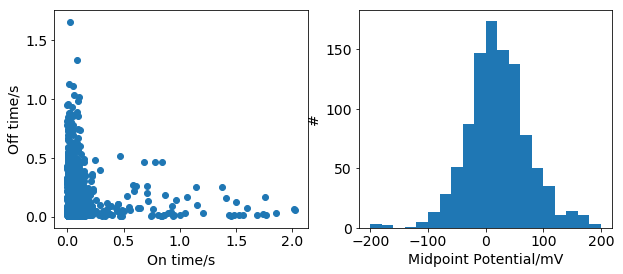

In [458]:
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
long_trace_files = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages(r'/home/biswajit/Downloads/multipdf_2nd.pdf')
for folder in [S83d10Sept16_Cu_50mV_300s]:
    homedir = folder
    fig_folder, ax_name = plt.subplots(figsize=(10, 1))
    ax_name.text(0.5, 0.5,'Foldername: '+homedir[:int(0.5*len(homedir))]+'\n'+homedir[int(0.5*len(homedir)):],
                 ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax_name.set_xticks([]);ax_name.set_yticks([])
    pdf.savefig(fig_folder)
    for pointnumbers in range(50):#range(20), [19]
        pointnumbers=[pointnumbers]
        for potential in [50, 75, 100]:
            potential=[potential]
            df_datn_emplot, df_FCS, folder = dir_mV_molNo(homedir)
            df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
            df_specific = df_specific[df_specific['Potential'].isin(potential)]; df_specific.reset_index(drop=True, inplace=True)
            f_emplot_path = df_specific['filepath[.em.plot]']
            if not f_emplot_path.empty:
                #name heading
                fig_name, ax_name = plt.subplots(figsize=(10, 1))
                ax_name.text(0.5, 0.5,'Point number:'+str(pointnumbers)+'    Potential:'+ str(potential),
                             ha='center', va='center', transform=ax.transAxes, fontsize=24)
                ax_name.set_xticks([]);ax_name.set_yticks([])
                #time trace
                fig_timetrace = time_trace_plot(foldername= homedir, input_potential=potential, pointnumbers=pointnumbers, x_lim_min=0, y_lim_min=0,
                                                x_lim_max=None, y_lim_max=6, bin=5, show_changepoint=False, figsize=(10, 4))
                #on-off histogram
                fig_on_off_hist, t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=potential, pointnumbers=pointnumbers,
                                          bins_on=100, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], plotting=True)
                # on-off trace plot
                fig_on_off_trace, axes = plt.subplots(1,2, figsize=(10, 4))
                axes[0].plot(t_ons)
                axes[0].set_ylabel('Time/s')
                axes[0].set_title("ON-time trace at %s mV of Point_%s" %(potential,pointnumbers), fontsize=12)
                axes[1].plot(t_offs)
                axes[0].set_ylabel('Time/s')
                axes[1].set_title("OFF-time trace at %s mV of Point_%s" %(potential,pointnumbers), fontsize=12)
                #dynamic correlation
                fig_dynamic_corr = dynamic_corr(t_ons=t_ons, t_offs=t_offs, potential=potential, pointnumbers=pointnumbers)
                #on-off scattered plot
                fig_scater = scatter_pot(t_ons=t_ons, t_offs=t_offs, potential=potential)
                pdf.savefig(fig_name)
                pdf.savefig(fig_timetrace)
                pdf.savefig(fig_on_off_hist)
                pdf.savefig(fig_on_off_trace)
                pdf.savefig(fig_dynamic_corr)
                pdf.savefig(fig_scater)
            else:
                continue
pdf.close()

### original t_on series

### Autocorr code

In [75]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
A multiple-τ algorithm for Python 2.7 and 3.x.

Copyright (c) 2014 Paul Müller

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

  1. Redistributions of source code must retain the above copyright
     notice, this list of conditions and the following disclaimer.

  2. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in
     the documentation and/or other materials provided with the
     distribution.

  3. Neither the name of multipletau nor the names of its contributors
     may be used to endorse or promote products derived from this
     software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
"AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL INFRAE OR
CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF
LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""
from __future__ import division

import numpy as np
import warnings

__all__ = ["autocorrelate", "correlate", "correlate_numpy"]


def autocorrelate(a, m=16, deltat=1, normalize=False,
                  copy=True, dtype=None):
    """
    Autocorrelation of a 1-dimensional sequence on a log2-scale.

    This computes the correlation similar to
    :py:func:`numpy.correlate` for positive :math:`k` on a base 2
    logarithmic scale.

        :func:`numpy.correlate(a, a, mode="full")[len(a)-1:]`

        :math:`z_k = \Sigma_n a_n a_{n+k}`


    Parameters
    ----------
    a : array-like
        input sequence
    m : even integer
        defines the number of points on one level, must be an
        even integer
    deltat : float
        distance between bins
    normalize : bool
        normalize the result to the square of the average input
        signal and the factor :math:`M-k`.
    copy : bool
        copy input array, set to ``False`` to save memory
    dtype : object to be converted to a data type object
        The data type of the returned array and of the accumulator
        for the multiple-tau computation.


    Returns
    -------
    autocorrelation : ndarray of shape (N,2)
        the lag time (1st column) and the autocorrelation (2nd column).

    Notes
    -----
    .. versionchanged :: 0.1.6
       Compute the correlation for zero lag time.

    The algorithm computes the correlation with the convention of the
    curve decaying to zero.

    For experiments like e.g. fluorescence correlation spectroscopy,
    the signal can be normalized to :math:`M-k`
    by invoking ``normalize = True``.

    For normalizing according to the behavior
    of :py:func:`numpy.correlate`, use ``normalize = False``.

    For complex arrays, this method falls back to the method
    :func:`correlate`.


    Examples
    --------
    >>> from multipletau import autocorrelate
    >>> autocorrelate(range(42), m=2, dtype=np.float_)
    array([[  0.00000000e+00,   2.38210000e+04],
           [  1.00000000e+00,   2.29600000e+04],
           [  2.00000000e+00,   2.21000000e+04],
           [  4.00000000e+00,   2.03775000e+04],
           [  8.00000000e+00,   1.50612000e+04]])
    """
    assert isinstance(copy, bool)
    assert isinstance(normalize, bool)

    if dtype is None:
        dtype = np.dtype(a[0].__class__)
    else:
        dtype = np.dtype(dtype)

    # Complex data
    if dtype.kind == "c":
        # run cross-correlation
        return correlate(a=a,
                         v=a,
                         m=m,
                         deltat=deltat,
                         normalize=normalize,
                         copy=copy,
                         dtype=dtype)
    elif dtype.kind != "f":
        warnings.warn("Input dtype is not float; casting to np.float_!")
        dtype = np.dtype(np.float_)

    # If copy is false and dtype is the same as the input array,
    # then this line does not have an effect:
    trace = np.array(a, dtype=dtype, copy=copy)

    # Check parameters
    if m // 2 != m / 2:
        mold = m
        m = np.int_((m // 2 + 1) * 2)
        warnings.warn("Invalid value of m={}. Using m={} instead"
                      .format(mold, m))
    else:
        m = np.int_(m)

    N = N0 = trace.shape[0]

    # Find out the length of the correlation function.
    # The integer k defines how many times we can average over
    # two neighboring array elements in order to obtain an array of
    # length just larger than m.
    k = np.int_(np.floor(np.log2(N / m)))

    # In the base2 multiple-tau scheme, the length of the correlation
    # array is (only taking into account values that are computed from
    # traces that are just larger than m):
    lenG = m + k * (m // 2) + 1

    G = np.zeros((lenG, 2), dtype=dtype)

    normstat = np.zeros(lenG, dtype=dtype)
    normnump = np.zeros(lenG, dtype=dtype)

    traceavg = np.average(trace)

    # We use the fluctuation of the signal around the mean
    if normalize:
        trace -= traceavg
        assert traceavg != 0, "Cannot normalize: Average of `a` is zero!"

    # Otherwise the following for-loop will fail:
    assert N >= 2 * m, "len(a) must be larger than 2m!"

    # Calculate autocorrelation function for first m+1 bins
    # Discrete convolution of m elements
    for n in range(0, m + 1):
        G[n, 0] = deltat * n
        # This is the computationally intensive step
        G[n, 1] = np.sum(trace[:N - n] * trace[n:])
        normstat[n] = N - n
        normnump[n] = N
    # Now that we calculated the first m elements of G, let us
    # go on with the next m/2 elements.
    # Check if len(trace) is even:
    if N % 2 == 1:
        N -= 1
    # Add up every second element
    trace = (trace[:N:2] + trace[1:N:2]) / 2
    N //= 2
    # Start iteration for each m/2 values
    for step in range(1, k + 1):
        # Get the next m/2 values via correlation of the trace
        for n in range(1, m // 2 + 1):
            npmd2 = n + m // 2
            idx = m + n + (step - 1) * m // 2
            if len(trace[:N - npmd2]) == 0:
                # This is a shortcut that stops the iteration once the
                # length of the trace is too small to compute a corre-
                # lation. The actual length of the correlation function
                # does not only depend on k - We also must be able to
                # perform the sum with respect to k for all elements.
                # For small N, the sum over zero elements would be
                # computed here.
                #
                # One could make this for-loop go up to maxval, where
                #   maxval1 = int(m/2)
                #   maxval2 = int(N-m/2-1)
                #   maxval = min(maxval1, maxval2)
                # However, we then would also need to find out which
                # element in G is the last element...
                G = G[:idx - 1]
                normstat = normstat[:idx - 1]
                normnump = normnump[:idx - 1]
                # Note that this break only breaks out of the current
                # for loop. However, we are already in the last loop
                # of the step-for-loop. That is because we calculated
                # k in advance.
                break
            else:
                G[idx, 0] = deltat * npmd2 * 2**step
                # This is the computationally intensive step
                G[idx, 1] = np.sum(trace[:N - npmd2] *
                                   trace[npmd2:])
                normstat[idx] = N - npmd2
                normnump[idx] = N
        # Check if len(trace) is even:
        if N % 2 == 1:
            N -= 1
        # Add up every second element
        trace = (trace[:N:2] + trace[1:N:2]) / 2
        N //= 2

    if normalize:
        G[:, 1] /= traceavg**2 * normstat
    else:
        G[:, 1] *= N0 / normnump

    return G


def correlate(a, v, m=16, deltat=1, normalize=False,
              copy=True, dtype=None):
    """
    Cross-correlation of two 1-dimensional sequences
    on a log2-scale.

    This computes the cross-correlation similar to
    :py:func:`numpy.correlate` for positive :math:`k`  on a base 2
    logarithmic scale.

        :func:`numpy.correlate(a, v, mode="full")[len(a)-1:]`

        :math:`z_k = \Sigma_n a_n v_{n+k}`

    Note that only the correlation in the positive direction is
    computed. To obtain the correlation for negative lag times
    swap the input variables ``a`` and ``v``.

    Parameters
    ----------
    a, v : array-like
        input sequences with equal length
    m : even integer
        defines the number of points on one level, must be an
        even integer
    deltat : float
        distance between bins
    normalize : bool
        normalize the result to the square of the average input
        signal and the factor :math:`M-k`.
    copy : bool
        copy input array, set to ``False`` to save memory
    dtype : object to be converted to a data type object
        The data type of the returned array and of the accumulator
        for the multiple-tau computation.


    Returns
    -------
    cross_correlation : ndarray of shape (N,2)
        the lag time (column 1) and the cross-correlation (column2).


    Notes
    -----
    .. versionchanged :: 0.1.6
       Compute the correlation for zero lag time and correctly
       normalize the correlation for a complex input sequence `v`.

    The algorithm computes the correlation with the convention of the
    curve decaying to zero.

    For experiments like e.g. fluorescence correlation spectroscopy,
    the signal can be normalized to :math:`M-k`
    by invoking ``normalize = True``.

    For normalizing according to the behavior of
    :py:func:`numpy.correlate`, use ``normalize = False``.


    Examples
    --------
    >>> from multipletau import correlate
    >>> correlate(range(42), range(1,43), m=2, dtype=np.float_)
    array([[  0.00000000e+00,   2.46820000e+04],
           [  1.00000000e+00,   2.38210000e+04],
           [  2.00000000e+00,   2.29600000e+04],
           [  4.00000000e+00,   2.12325000e+04],
           [  8.00000000e+00,   1.58508000e+04]])

    """
    assert isinstance(copy, bool)
    assert isinstance(normalize, bool)
    # See `autocorrelation` for better documented code.
    traceavg1 = np.average(v)
    traceavg2 = np.average(a)
    if normalize:
        assert traceavg1 != 0, "Cannot normalize: Average of `v` is zero!"
        assert traceavg2 != 0, "Cannot normalize: Average of `a` is zero!"

    if dtype is None:
        dtype = np.dtype(v[0].__class__)
        dtype2 = np.dtype(a[0].__class__)
        if dtype != dtype2:
            if dtype.kind == "c" or dtype2.kind == "c":
                # The user might try to combine complex64 and float128.
                warnings.warn(
                    "Input dtypes not equal; casting to np.complex_!")
                dtype = np.dtype(np.complex_)
            else:
                warnings.warn("Input dtypes not equal; casting to np.float_!")
                dtype = np.dtype(np.float_)
    else:
        dtype = np.dtype(dtype)

    if dtype.kind not in ["c", "f"]:
        warnings.warn("Input dtype is not float; casting to np.float_!")
        dtype = np.dtype(np.float_)

    trace1 = np.array(v, dtype=dtype, copy=copy)

    # Prevent traces from overwriting each other
    if a is v:
        # Force copying trace 2
        copy = True

    trace2 = np.array(a, dtype=dtype, copy=copy)

    assert trace1.shape[0] == trace2.shape[0], "`a`,`v` must have same length!"

    # Complex data
    if dtype.kind == "c":
        np.conjugate(trace1, out=trace1)

    # Check parameters
    if m // 2 != m / 2:
        mold = m
        m = np.int_(m // 2 + 1) * 2
        warnings.warn("Invalid value of m={}. Using m={} instead"
                      .format(mold, m))
    else:
        m = np.int_(m)

    N = N0 = trace1.shape[0]
    # Find out the length of the correlation function.
    # The integer k defines how many times we can average over
    # two neighboring array elements in order to obtain an array of
    # length just larger than m.
    k = np.int_(np.floor(np.log2(N / m)))

    # In the base2 multiple-tau scheme, the length of the correlation
    # array is (only taking into account values that are computed from
    # traces that are just larger than m):
    lenG = m + k * m // 2 + 1

    G = np.zeros((lenG, 2), dtype=dtype)
    normstat = np.zeros(lenG, dtype=dtype)
    normnump = np.zeros(lenG, dtype=dtype)

    # We use the fluctuation of the signal around the mean
    if normalize:
        trace1 -= np.conj(traceavg1)
        trace2 -= traceavg2

    # Otherwise the following for-loop will fail:
    assert N >= 2 * m, "len(a) must be larger than 2m!"

    # Calculate autocorrelation function for first m+1 bins
    for n in range(0, m + 1):
        G[n, 0] = deltat * n
        G[n, 1] = np.sum(trace1[:N - n] * trace2[n:])
        normstat[n] = N - n
        normnump[n] = N
    # Check if len(trace) is even:
    if N % 2 == 1:
        N -= 1
    # Add up every second element
    trace1 = (trace1[:N:2] + trace1[1:N:2]) / 2
    trace2 = (trace2[:N:2] + trace2[1:N:2]) / 2
    N //= 2

    for step in range(1, k + 1):
        # Get the next m/2 values of the trace
        for n in range(1, m // 2 + 1):
            npmd2 = (n + m // 2)
            idx = m + n + (step - 1) * m // 2
            if len(trace1[:N - npmd2]) == 0:
                # Abort
                G = G[:idx - 1]
                normstat = normstat[:idx - 1]
                normnump = normnump[:idx - 1]
                break
            else:
                G[idx, 0] = deltat * npmd2 * 2**step
                G[idx, 1] = np.sum(
                    trace1[:N - npmd2] * trace2[npmd2:])
                normstat[idx] = N - npmd2
                normnump[idx] = N

        # Check if len(trace) is even:
        if N % 2 == 1:
            N -= 1
        # Add up every second element
        trace1 = (trace1[:N:2] + trace1[1:N:2]) / 2
        trace2 = (trace2[:N:2] + trace2[1:N:2]) / 2
        N //= 2

    if normalize:
        G[:, 1] /= traceavg1 * traceavg2 * normstat
    else:
        G[:, 1] *= N0 / normnump

    return G


def correlate_numpy(a, v, deltat=1, normalize=False,
                    dtype=None, copy=True):
    """
    Convenience function that wraps around :py:func:`numpy.correlate` and
    returns the correlation in the same format as :func:`correlate` does.


    Parameters
    ----------
    a, v : array-like
        input sequences
    deltat : float
        distance between bins
    normalize : bool
        normalize the result to the square of the average input signal
        and the factor :math:`M-k`. The resulting curve follows
        the convention of decaying to zero for large lag times.
    copy : bool
        copy input array, set to ``False`` to save memory
    dtype : object to be converted to a data type object
        The data type of the returned array.


    Returns
    -------
    cross_correlation : ndarray of shape (N,2)
        the lag time (column 1) and the cross-correlation (column 2).


    Notes
    -----
    .. versionchanged :: 0.1.6
       Removed false normalization when `normalize==False`.
    """
    ab = np.array(a, dtype=dtype, copy=copy)
    vb = np.array(v, dtype=dtype, copy=copy)

    assert ab.shape[0] == vb.shape[0], "`a`,`v` must have same length!"

    avg = np.average(ab)
    vvg = np.average(vb)

    if normalize:
        ab -= avg
        vb -= vvg
        assert avg != 0, "Cannot normalize: Average of `a` is zero!"
        assert vvg != 0, "Cannot normalize: Average of `v` is zero!"

    Gd = np.correlate(ab, vb, mode="full")[len(ab) - 1:]

    if normalize:
        N = len(Gd)
        m = N - np.arange(N)
        Gd /= m * avg * vvg

    G = np.zeros((len(Gd), 2), dtype=dtype)
    G[:, 1] = Gd
    G[:, 0] = np.arange(len(Gd)) * deltat
    return G


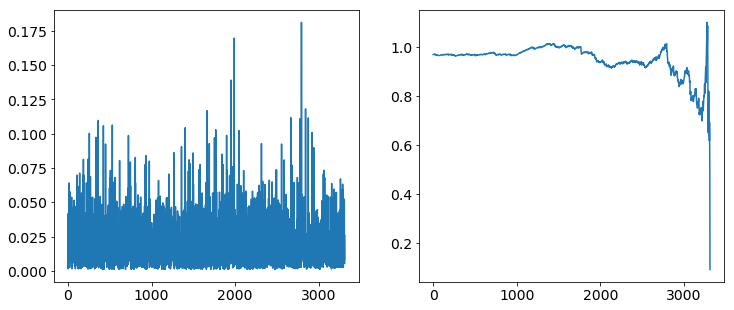

In [6]:
temp = t_ons[t_ons>1e-3]
tau_on_i = temp[len(temp)/2:-500];
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
for i in range(len(tau_on_i)-1):#len(tau_on_i)-1
    t_i = tau_on_i[i:-1];
    t_j = tau_on_i[i+1:];
    t_ij_temp = sum(t_i * t_j)/(len(t_i)*average(tau_on_i)**2)
    t_ij = np.append(t_ij,t_ij_temp)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(t_ij)

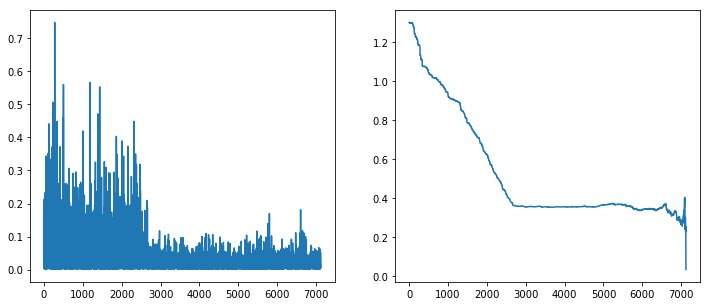

In [140]:
temp = t_ons[t_ons>1e-3]
tau_on_i = temp[:-500];
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
for i in range(len(tau_on_i)-1):#len(tau_on_i)-1
    t_i = tau_on_i[i:-1];
    t_j = tau_on_i[i+1:];
    t_ij_temp = sum(t_i * t_j)/(len(t_i)*average(tau_on_i)**2)
    t_ij = np.append(t_ij,t_ij_temp)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(t_ij)

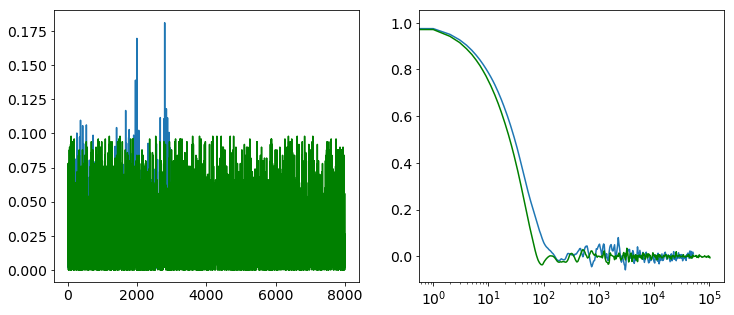

In [65]:
temp = t_ons[t_ons>1e-3]
tau_on_i = temp[len(temp)/2:-500];
os.chdir('/home/biswajit/Downloads/temp')
t_mac = []; t_mic = [];
for i in tau_on_i:
    t_ms = round(i*1000)#converting s to ms
    t_mic_temp = t_ms*np.ones(t_ms);
    t_mic = np.append(t_mic, t_mic_temp)
t_mac = linspace(1,100, 100)#len(t_mic)
G = autocorrelate(t_mic, m=50, deltat=1, normalize=True)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(G[:,0], G[:,1]/max(G[:,1]))
axes[1].set_xscale('log')
#------
temp = t_ons_generated
tau_on_i = temp;
t_mac = []; t_mic = [];
for i in tau_on_i:
    t_ms = round(i*1000)#converting s to ms
    t_mic_temp = t_ms*np.ones(t_ms);
    t_mic = np.append(t_mic, t_mic_temp)
t_mac = linspace(1,100, 100)#len(t_mic)
G = autocorrelate(t_mic, m=50, deltat=1, normalize=True)
axes[0].plot(tau_on_i, 'g')
axes[1].plot(G[:,0], G[:,1]/max(G[:,1]), 'g')
axes[1].set_xscale('log')

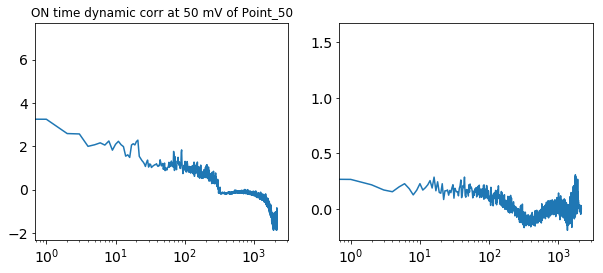

In [402]:
def dynamic_corr(t_ons=t_ons, t_offs=t_offs, potential=50, pointnumbers=50):
    temp = t_ons;#[t_ons>1e-3]
    tau = temp[:-1];#[len(temp)/2:-500]
    t_ij = [];
#     times = logspace(12, 0, 100, base=2);
#     times=times.astype(int);
#     times = sort(times)
    for i in range(len(tau)-1):#range(len(tau_on_i)-1)
        D_t = tau[:(-1-i)]-average(tau);
        D_t_T = tau[i:-1]-average(tau);
        t_ij_temp = average(D_t * D_t_T)/(average(tau)**2)
        t_ij = np.append(t_ij,t_ij_temp)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(t_ij[:-100])
    axes[0].set_xscale('log')
    axes[0].set_title("ON time dynamic corr at %s mV of Point_%s" %(potential, pointnumbers), fontsize=12)
    temp = t_offs;#[t_ons>1e-3]
    tau = temp[:-1];#[len(temp)/2:-500]
    t_ij = [];
#     times = logspace(12, 0, 100, base=2);
#     times=times.astype(int);
#     times = sort(times)
    for i in range(len(tau)-1):#range(len(tau_on_i)-1)
        D_t = tau[:(-1-i)]-average(tau);
        D_t_T = tau[i:-1]-average(tau);
        t_ij_temp = average(D_t * D_t_T)/(average(tau)**2)
        t_ij = np.append(t_ij,t_ij_temp)
    axes[1].plot(t_ij[:-100])
    axes[1].set_xscale('log')
    axes[0].set_title("ON time dynamic corr at %s mV of Point_%s" %(potential, pointnumbers), fontsize=12)
    return(fig)
fig = dynamic_corr()

### simulated t_on series

In [45]:
prob_on = n_on/max(n_on); prob_on = prob_on/sum(prob_on);
prob_off = n_off/max(n_off); prob_off = prob_off/sum(prob_off);
data_points = 8e3
t_ons_generated = np.random.choice(bins_on[:-1], data_points, p=prob_on)
t_off_generated = np.random.choice(bins_off[:-1], data_points, p=prob_off)

In [44]:
tau_on_i = t_ons_generated;
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
length=[];
for i in range(200):#len(tau_on_i)-1
    t_i = tau_on_i[i];
    t_j = tau_on_i[i+1:];
    t_ij_temp = t_i * t_j
    t_ij = np.append(t_ij,t_ij_temp)
    length_temp = len(t_ij)
    length.append(length_temp)
#     if len(t_ij)>1e6:
#         np.save('t_ij'+str(i), t_ij)
#         t_ij = []
# np.save('t_ij'+str(i), t_ij)
# print(length)

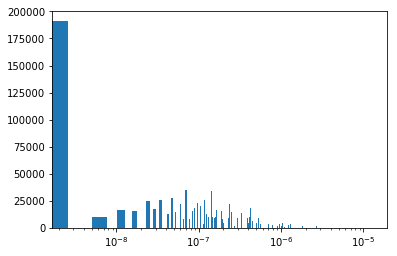

In [45]:
hist(t_ij/sum(t_ij), bins=5000);
xscale('log')

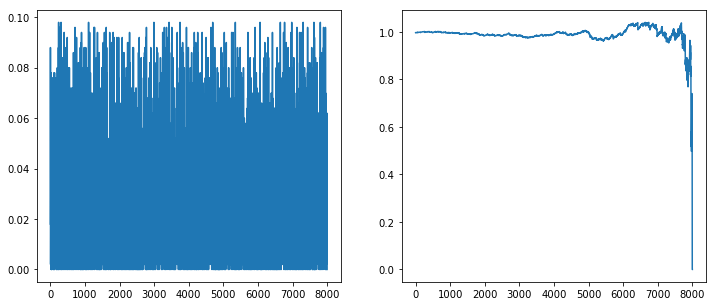

In [141]:
temp = t_ons_generated
tau_on_i = temp;
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
length=[];
for i in range(len(tau_on_i)-1):#len(tau_on_i)-1
    t_i = tau_on_i[i:-1];
    t_j = tau_on_i[i+1:];
    t_ij_temp = sum(t_i * t_j)/(len(t_i)*average(tau_on_i)**2)
    t_ij = np.append(t_ij,t_ij_temp)
    length_temp = len(t_ij)
    length.append(length_temp)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(t_ij)

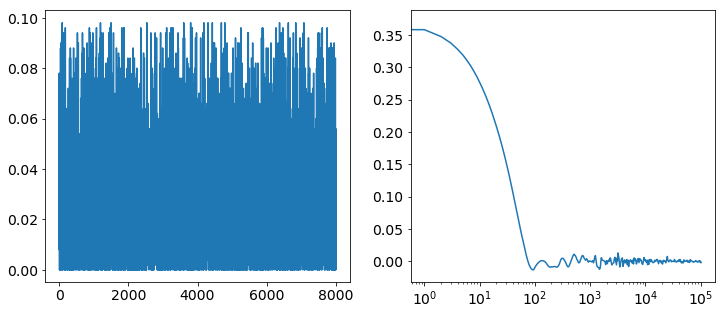

In [46]:
temp = t_ons_generated
tau_on_i = temp;
t_mac = []; t_mic = [];
for i in tau_on_i:
    t_ms = round(i*1000)#converting s to ms
    t_mic_temp = t_ms*np.ones(t_ms);
    t_mic = np.append(t_mic, t_mic_temp)
t_mac = linspace(1,100, 100)#len(t_mic)
G = autocorrelate(t_mic, m=50, deltat=1, normalize=True)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(G[:,0], G[:,1])
axes[1].set_xscale('log')

### constant t_on

In [100]:
t_on_av = average(t_ons)
t_on_cost = np.ones(8e3)*t_on_av
t_on_av

0.034346279623859895

In [65]:
tau_on_i = t_on_cost;
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
length=[];
for i in range(200):#len(tau_on_i)-1
    t_i = tau_on_i[i];
    t_j = tau_on_i[i+1:];
    t_ij_temp = t_i * t_j
    t_ij = np.append(t_ij,t_ij_temp)
    length_temp = len(t_ij)
    length.append(length_temp)
#     if len(t_ij)>1e6:
#         np.save('t_ij'+str(i), t_ij)
#         t_ij = []
# np.save('t_ij'+str(i), t_ij)
# print(length)

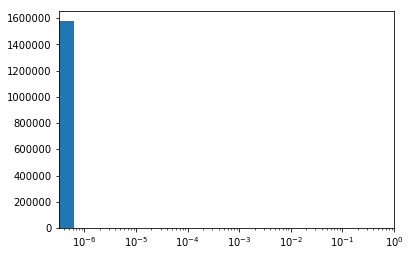

In [66]:
hist(t_ij/sum(t_ij), bins=5000);
xscale('log')

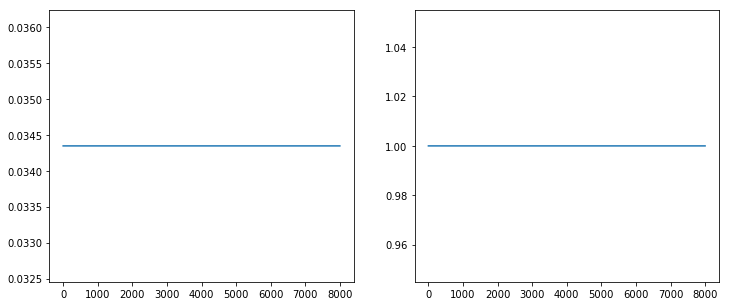

In [142]:
temp = t_on_cost;
tau_on_i = temp;
os.chdir('/home/biswajit/Downloads/temp')
t_ij = [];
length=[];
for i in range(len(tau_on_i)-1):#len(tau_on_i)-1
    t_i = tau_on_i[i:-1];
    t_j = tau_on_i[i+1:];
    t_ij_temp = sum(t_i * t_j)/(len(t_i)*t_on_av**2)
    t_ij = np.append(t_ij,t_ij_temp)
    length_temp = len(t_ij)
    length.append(length_temp)
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(tau_on_i)
axes[1].plot(t_ij)